# Example_8_2

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/OTBD/main/content/init.py
import init; init.init(force_download=False)

In [1]:
from local.lib.Generation import scenarios_regression
import cvxpy as cp
from local.lib.utils import solver_cvx, grad_FOM, grad_FOM_decay, ista_lasso, fista_lasso, eval_loss, make_graph, ridge_tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%load_ext tensorboard

2023-10-19 10:46:03.371015: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now, let's consider the LASSO problem
$$\min_{{\bf{x}}} \frac{1}{n}\left\Vert {\bf{A}}{\bf{x}}-{\bf{b}}\right\Vert _{2}^{2}+\lambda\left\Vert {\bf{x}}\right\Vert _{1}$$

Solve it using symbolic computation and plot the **computational graph**.

In [2]:
# Loading scenarios
# ===========================
scenario=4
data_class, set_up =scenarios_regression(scenario)


# Definition of the problem
#===================================
loss_fn = lambda n, X, Y, w: (1/n)*cp.pnorm(X @ w - Y, p=2)**2
reg_L1 = lambda w: cp.pnorm(w, p=1)
loss_lasso = lambda n, X, Y, w, lambd: loss_fn(n, X, Y, w) + lambd * reg_L1(w)

subgrad_lasso = lambda n, X, Y, w, lambd: (2/n)*X.T@(X@w-Y)+lambd*np.sign(w)
grad_LS = lambda n, X, Y, w, lambd: (2/n)*X.T@(X@w-Y);


# Solution of the empirical risk using CVX
#=========================================
w_lasso_cvx=solver_cvx(set_up,loss_lasso)

w = cp.Variable(w_lasso_cvx.shape[0])
w.value = w_lasso_cvx 
loss_opt=loss_lasso(set_up['Niter_train'],set_up['Xtrain'][:,:set_up['d']+1],set_up['ytrain'][:,0],w,set_up['Lambda']).value

# Gradient descent
out_subgd =grad_FOM(set_up,subgrad_lasso)
out_subgd_decay =grad_FOM_decay(set_up,subgrad_lasso)

loss_subgrad=eval_loss(out_subgd,set_up,loss_lasso)
loss_subgrad_decay=eval_loss(out_subgd_decay,set_up,loss_lasso)

out_ista=ista_lasso(set_up,grad_LS)
out_fista=fista_lasso(set_up,grad_LS)

loss_ista=eval_loss(out_ista,set_up,loss_lasso)
loss_fista=eval_loss(out_fista,set_up,loss_lasso)

#TF symbolic computation
@tf.function
def loss_LS_L1_TF(Xtrain, Ytrain, w, lamb): 
    return tf.reduce_mean(tf.square((tf.matmul(Xtrain,w)-Ytrain))) + lamb*tf.norm(w, ord=1)

out_tf = ridge_tf(set_up,loss_LS_L1_TF)
loss_tf=eval_loss(out_tf.T,set_up,loss_lasso)

## Let's plot the computational graph

In [3]:
!rm -rf logs
w = tf.Variable(initial_value=np.array(set_up["Initial"]).reshape(-1,1), dtype=tf.float32)
Xtrain = set_up['Xtrain'][:,:set_up['d']+1]
Xtrain =  Xtrain.astype(np.float32)
Ytrain = np.array(set_up['ytrain'][:,0]).reshape(-1,1).astype(np.float32)
lamb = set_up["Lambda"]
make_graph(loss_LS_L1_TF, Xtrain,Ytrain,w,lamb, logdir="logs")

In [4]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 47595), started 16:25:00 ago. (Use '!kill 47595' to kill it.)

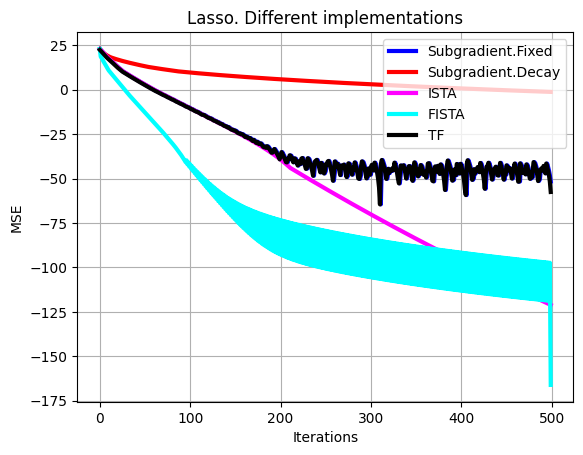

In [5]:
# Plot of learning curves
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_subgrad-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='b', linewidth = 3, label = 'Subgradient.Fixed')
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_subgrad_decay-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='r', linewidth = 3, label = 'Subgradient.Decay')
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_ista-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='magenta', linewidth = 3, label = 'ISTA'),
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_fista-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='cyan', linewidth = 3, label = 'FISTA')
plt.plot(np.arange(0,set_up['Niter_train']),10*np.log10(np.sum((loss_tf-loss_opt*np.ones((1,set_up['Niter_train'])))**2,axis=0)),color='black', linewidth = 3, label = 'TF')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.grid()
plt.legend(loc='upper right')
plt.title('Lasso. Different implementations')
plt.show()